#Avaliação - Parte Prática

Aplicação com redes neurais para a área de saúde. O objetivo é obter um modelo de predição de uma doença baseado em dados de exames clínicos laboratoriais.




In [112]:
# Importando as bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

###Importanto Banco de Dados

In [154]:
# Carregando os dados para treinamento e teste
data_train = pd.read_csv(
    "https://media.githubusercontent.com/media/psi3471/datasets/main/disease_prediction/disease_train.csv"
).drop(columns=["Unnamed: 0"])

data_test = pd.read_csv(
    "https://media.githubusercontent.com/media/psi3471/datasets/main/disease_prediction/disease_test.csv"
).drop(columns=["Unnamed: 0"])

print('Tamanho da base de dados do treinamento: ', data_train.shape)
print('Tamanho da base de dados do teste: ', data_test.shape)
display(data_train.head(2))

Tamanho da base de dados do treinamento:  (614, 9)
Tamanho da base de dados do teste:  (154, 9)


,0,1,2,3,4,5,6,7,8
0,6.0,123.0,72.0,45.000000,230.000000,33.6,0.733,34.0,0.0
1,7.0,159.0,66.0,20.536458,79.799479,30.4,0.383,36.0,1.0


##Valores dos Hiperparâmetros

### Modelo de Regressão Logística de um neurônio

In [37]:
# Fixando seeds para poder reproduzir os resultados
np.random.seed(111)
torch.manual_seed(111)
torch.cuda.manual_seed(111)

# Ajuste de hiperparâmetros
eta = 0.0005  # passo de adaptação da rede MLP
Nb = 100     # Tamanho do mini-batch
Ne = 4000    # Número de épocas

dados_treino = torch.tensor(data_train.values, dtype=torch.float32)
train_set = [
    (dados_treino[:, [0, 1, 2, 3, 4, 5, 6, 7]], dados_treino[:, [8]])
    for i in range(dados_treino.shape[0])
]
train_loader = torch.utils.data.DataLoader(train_set, batch_size=Nb, shuffle=True)

class regressaoLogistica(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(8, 1),
        nn.Sigmoid(),           
    )
  def forward(self, x):
      output = self.model(x)
      return output

########################################################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")    
model = regressaoLogistica().to(device=device)
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=eta)
########################################################################
xteste = torch.tensor(data_test.values[:,[0,1,2,3,4,5,6,7]], dtype=torch.float32).to(device=device)
dteste = torch.tensor(data_test.values[:,[8]], dtype=torch.float32).to(device=device)
########################################################################

# Lista usada para guardar o valor da função custo ao longo das iterações
losses_treinamento= []; losses_teste= []; Acuracia= []; TaxaDeErro= []; Precisao= []; Sensibilidade= []; F1Score = []

print('Desempenho do modelo de regressão logística com um único neurônio: \n')
for epoch in range(Ne):         # Loop dos mini batches, é usado o DataLoader para obter os sinais de entrada e desejado, X e d
    for n, (X, d) in enumerate(train_loader):
        X = X.to(device=device) # Envia os dados para a GPU, caso ela exista
        d = d.to(device=device)
        model.train()           # Coloca o modelo em modo treinamento; Zera informações de gradientes; Calcula a saída; Calcula o valor da função custo;
        model.zero_grad()       # Calcula os gradientes; Atualiza os pesos do modelo; Armazena o valor da função custo
        y = model(X)
        loss = loss_function(y, d)
        loss.backward()
        optimizer.step()
    
    model.eval()
    with torch.no_grad():       # Validação cruzada
        yteste = model(xteste)
        loss = loss_function(yteste, dteste)

        yteste_np = yteste.cpu().detach().numpy()
        yteste_np_dec = np.sign(yteste_np - 0.5)
        for i in range(len(yteste_np_dec)):
          if yteste_np_dec[i] == -1.0:
            yteste_np_dec[i] = 0.0

        losses_treinamento.append(round(loss.item(), 4))

    # Matriz de Confusão:
    VP = 0; VN = 0; FP = 0; FN = 0
    for i in range(len(yteste_np_dec)):
      if (data_test.values[:,[8]][i] - yteste_np_dec[i]) == 0.0 and yteste_np_dec[i] == 1.0: #VP
        VP += 1
      elif (data_test.values[:,[8]][i] - yteste_np_dec[i]) == 0.0 and yteste_np_dec[i] == 0.0: #VN
        VN += 1
      elif (data_test.values[:,[8]][i] - yteste_np_dec[i]) == 1.0: #FN
        FN += 1
      elif (data_test.values[:,[8]][i] - yteste_np_dec[i]) == -1.0: #FN
        FP += 1

    # Parâmetros da Matriz:
    Acuracia.append(round((VP+VN)/(VP+VN+FP+FN),4))
    TaxaDeErro.append(round(1 - Acuracia[-1],4))
    Precisao.append(round(VP/(VP + FP),4))
    Sensibilidade.append(round(VP/(VP + FN),4))
    F1Score.append(round(2*Precisao[-1]*Sensibilidade[-1]/(Precisao[-1]+Sensibilidade[-1]),4))
    
    # Mostra o valor da função custo a cada 100 épocas        
    if epoch % 100 == 0:
        print(f"Época: {epoch} ->  Train: {losses_treinamento[-1]} / Acurac:{Acuracia[-1]} / Erro:{TaxaDeErro[-1]} / ",
              f"Preci: {Precisao[-1]} / Sensi:{Sensibilidade[-1]} / F1Score:{F1Score[-1]} / Y1: {yteste_np[0]}")

Desempenho do modelo de regressão logística com um único neurônio: 

Época: 0 ->  Train: 0.6748 / Acurac:0.3247 / Erro:0.6753 /  Preci: 0.3203 / Sensi:1.0 / F1Score:0.4852 / Y1: [1.]
Época: 100 ->  Train: 0.2601 / Acurac:0.7078 / Erro:0.2922 /  Preci: 0.5714 / Sensi:0.3265 / F1Score:0.4156 / Y1: [0.6514595]
Época: 200 ->  Train: 0.2558 / Acurac:0.7143 / Erro:0.2857 /  Preci: 0.5862 / Sensi:0.3469 / F1Score:0.4359 / Y1: [0.64761996]
Época: 300 ->  Train: 0.2511 / Acurac:0.7208 / Erro:0.2792 /  Preci: 0.6071 / Sensi:0.3469 / F1Score:0.4415 / Y1: [0.650122]
Época: 400 ->  Train: 0.2459 / Acurac:0.7273 / Erro:0.2727 /  Preci: 0.6207 / Sensi:0.3673 / F1Score:0.4615 / Y1: [0.65733075]
Época: 500 ->  Train: 0.2397 / Acurac:0.7273 / Erro:0.2727 /  Preci: 0.6129 / Sensi:0.3878 / F1Score:0.475 / Y1: [0.6822848]
Época: 600 ->  Train: 0.2311 / Acurac:0.7143 / Erro:0.2857 /  Preci: 0.5714 / Sensi:0.4082 / F1Score:0.4762 / Y1: [0.7257449]
Época: 700 ->  Train: 0.2141 / Acurac:0.7013 / Erro:0.2987 / 


 Validação do Modelo: 

 Época: 4000 ->  Train: 0.1893 / Acurac:0.7143 / Erro:0.2857 /  Preci: 0.561 / Sensi:0.4694 / F1Score:0.5111



Text(0, 0.5, 'Perda [%]')

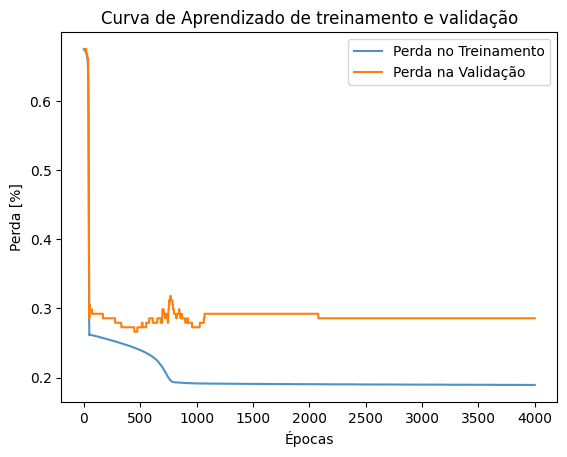

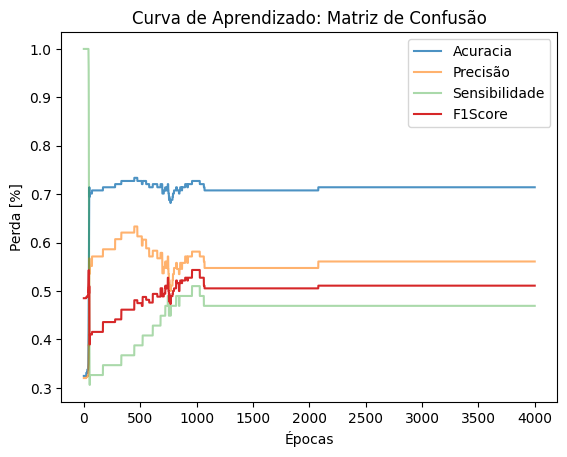

In [66]:
# Validação do Modelo:
print(f"\n Validação do Modelo: \n\n Época: {epoch+1} ->  Train: {losses_treinamento[-1]} / Acurac:{Acuracia[-1]} / Erro:{TaxaDeErro[-1]} / ",
      f"Preci: {Precisao[-1]} / Sensi:{Sensibilidade[-1]} / F1Score:{F1Score[-1]}\n")

plt.figure()
plt.plot(losses_treinamento, alpha=0.8)
plt.plot(TaxaDeErro)
plt.title('Curva de Aprendizado de treinamento e validação')
plt.legend(["Perda no Treinamento", "Perda na Validação"])
plt.xlabel("Épocas")
plt.ylabel("Perda [%]")

plt.figure()
plt.plot(Acuracia, alpha=0.8)
plt.plot(Precisao, alpha=0.6)
plt.plot(Sensibilidade, alpha=0.4)
plt.plot(F1Score)
plt.title('Curva de Aprendizado: Matriz de Confusão')
plt.legend(["Acuracia", "Precisão", "Sensibilidade", "F1Score"])
plt.xlabel("Épocas")
plt.ylabel("Perda [%]")

## Arquitetura do meu modelo:
### Para reduzir o overfitting serão usadas as seguintes ferramentas:
#### - Validação Cruzada
#### - Função de Ativação Sigmoid()
#### - Dropout
#### - Inicialização dos Pesos Xavier (para Sigmoid)

Não será usado o otimizador Adams porque o problema consta com poucos dados.

In [247]:
# Fixando seeds para poder reproduzir os resultados
np.random.seed(111)
torch.manual_seed(111)
torch.cuda.manual_seed(111)

# Ajuste de hiperparâmetros
eta = 0.01  # passo de adaptação da rede MLP
Nb = 50     # Tamanho do mini-batch
Ne = 4000    # Número de épocas

dados_treino = torch.tensor(data_train.values, dtype=torch.float32)
train_set = [
    (dados_treino[:, [0, 1, 2, 3, 4, 5, 6, 7]], dados_treino[:, [8]])
    for i in range(dados_treino.shape[0])
]
train_loader = torch.utils.data.DataLoader(train_set, batch_size=Nb, shuffle=True)

class regressaoLogistica(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(8, 6),
        nn.Sigmoid(),
        nn.Dropout(0.3), 

        nn.Linear(6, 3),
        nn.Sigmoid(),
        nn.Dropout(0.3),

        nn.Linear(3, 1),   
        nn.Sigmoid(),      
    )
  def forward(self, x):
      output = self.model(x)
      return output

########################################################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")    
model = regressaoLogistica().to(device=device)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        torch.nn.init.xavier_uniform_(m.weight, gain=1)
        torch.nn.init.zeros_(m.bias)

model.apply(weights_init)

loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=eta)
########################################################################
xteste = torch.tensor(data_test.values[:,[0,1,2,3,4,5,6,7]], dtype=torch.float32).to(device=device)
dteste = torch.tensor(data_test.values[:,[8]], dtype=torch.float32).to(device=device)
########################################################################

# Lista usada para guardar o valor da função custo ao longo das iterações
losses_treinamento= []; losses_teste= []; Acuracia= []; TaxaDeErro= []; Precisao= []; Sensibilidade= []; F1Score = []

print('Desempenho do modelo de regressão logística com um único neurônio: \n')
for epoch in range(Ne):         # Loop dos mini batches, é usado o DataLoader para obter os sinais de entrada e desejado, X e d
    for n, (X, d) in enumerate(train_loader):
        X = X.to(device=device) # Envia os dados para a GPU, caso ela exista
        d = d.to(device=device)
        model.train()           # Coloca o modelo em modo treinamento; Zera informações de gradientes; Calcula a saída; Calcula o valor da função custo;
        model.zero_grad()       # Calcula os gradientes; Atualiza os pesos do modelo; Armazena o valor da função custo
        y = model(X)
        loss = loss_function(y, d)
        loss.backward()
        optimizer.step()
    
    model.eval()
    with torch.no_grad():       # Validação cruzada
        yteste = model(xteste)
        loss = loss_function(yteste, dteste)

        yteste_np = yteste.cpu().detach().numpy()
        yteste_np_dec = np.sign(yteste_np - 0.35)
        for i in range(len(yteste_np_dec)):
          if yteste_np_dec[i] == -1.0:
            yteste_np_dec[i] = 0.0

        losses_treinamento.append(round(loss.item(), 4))

    # Matriz de Confusão:
    VP = 0; VN = 0; FP = 0; FN = 0
    for i in range(len(yteste_np_dec)):
      if (data_test.values[:,[8]][i] - yteste_np_dec[i]) == 0.0 and yteste_np_dec[i] == 1.0: #VP
        VP += 1
      elif (data_test.values[:,[8]][i] - yteste_np_dec[i]) == 0.0 and yteste_np_dec[i] == 0.0: #VN
        VN += 1
      elif (data_test.values[:,[8]][i] - yteste_np_dec[i]) == 1.0: #FN
        FN += 1
      elif (data_test.values[:,[8]][i] - yteste_np_dec[i]) == -1.0: #FN
        FP += 1

    # Parâmetros da Matriz:
    Acuracia.append(round((VP+VN)/(VP+VN+FP+FN),4))
    TaxaDeErro.append(round(1 - Acuracia[-1],4))
    if (VP + FP) != 0 and (VP + FN) != 0:
      Precisao.append(round(VP/(VP + FP),4))
      Sensibilidade.append(round(VP/(VP + FN),4))
      F1Score.append(round(2*Precisao[-1]*Sensibilidade[-1]/(Precisao[-1]+Sensibilidade[-1]),4))
    else:
      Precisao.append(0)
      Sensibilidade.append(0)
      F1Score.append(0)

    # Mostra o valor da função custo a cada 100 épocas        
    if epoch % 100 == 0:
        print(f"Época: {epoch} ->  Train: {losses_treinamento[-1]} / Acurac:{Acuracia[-1]} / Erro:{TaxaDeErro[-1]} / ",
              f"Preci: {Precisao[-1]} / Sensi:{Sensibilidade[-1]} / F1Score:{F1Score[-1]} / Y1: {yteste_np[0]}")

Desempenho do modelo de regressão logística com um único neurônio: 

Época: 0 ->  Train: 0.2218 / Acurac:0.6818 / Erro:0.3182 /  Preci: 0 / Sensi:0 / F1Score:0 / Y1: [0.25965753]
Época: 100 ->  Train: 0.2165 / Acurac:0.5714 / Erro:0.4286 /  Preci: 0.3191 / Sensi:0.3061 / F1Score:0.3125 / Y1: [0.3490734]
Época: 200 ->  Train: 0.2164 / Acurac:0.5714 / Erro:0.4286 /  Preci: 0.4124 / Sensi:0.8163 / F1Score:0.548 / Y1: [0.36007765]
Época: 300 ->  Train: 0.2159 / Acurac:0.5714 / Erro:0.4286 /  Preci: 0.4124 / Sensi:0.8163 / F1Score:0.548 / Y1: [0.36279437]
Época: 400 ->  Train: 0.2153 / Acurac:0.5974 / Erro:0.4026 /  Preci: 0.4301 / Sensi:0.8163 / F1Score:0.5634 / Y1: [0.36444592]
Época: 500 ->  Train: 0.2148 / Acurac:0.6299 / Erro:0.3701 /  Preci: 0.45 / Sensi:0.7347 / F1Score:0.5581 / Y1: [0.3638544]
Época: 600 ->  Train: 0.2142 / Acurac:0.6364 / Erro:0.3636 /  Preci: 0.4578 / Sensi:0.7755 / F1Score:0.5757 / Y1: [0.36766237]
Época: 700 ->  Train: 0.2138 / Acurac:0.6429 / Erro:0.3571 /  Pre

KeyboardInterrupt: ignored


 Validação do Modelo: 

 Época: 3144 ->  Train: 0.2063 / Acurac:0.6494 / Erro:0.3506 /  Preci: 0.4576 / Sensi:0.551 / F1Score:0.5



Text(0, 0.5, 'Perda [%]')

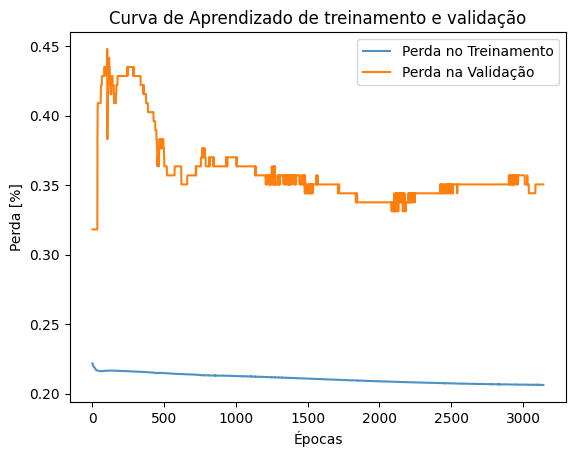

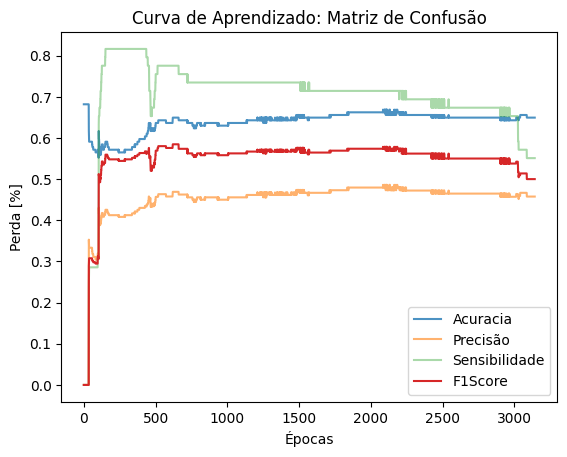

In [248]:
# Validação do Modelo:
print(f"\n Validação do Modelo: \n\n Época: {epoch+1} ->  Train: {losses_treinamento[-1]} / Acurac:{Acuracia[-1]} / Erro:{TaxaDeErro[-1]} / ",
      f"Preci: {Precisao[-1]} / Sensi:{Sensibilidade[-1]} / F1Score:{F1Score[-1]}\n")

plt.figure()
plt.plot(losses_treinamento, alpha=0.8)
plt.plot(TaxaDeErro)
plt.title('Curva de Aprendizado de treinamento e validação')
plt.legend(["Perda no Treinamento", "Perda na Validação"])
plt.xlabel("Épocas")
plt.ylabel("Perda [%]")

plt.figure()
plt.plot(Acuracia, alpha=0.8)
plt.plot(Precisao, alpha=0.6)
plt.plot(Sensibilidade, alpha=0.4)
plt.plot(F1Score)
plt.title('Curva de Aprendizado: Matriz de Confusão')
plt.legend(["Acuracia", "Precisão", "Sensibilidade", "F1Score"])
plt.xlabel("Épocas")
plt.ylabel("Perda [%]")